# <center>Multivariate Regression Example: Public School Budget Breakdown and Poverty Rates</center>

## Intro

The Census's summary of school finances provides a clear breakdown of school district budgets, showing how much money goes to each of the main categories you would expect in a district budget. This includes things like instruction, infrastructure, support services etc. In this post I'm going to create a multivariate regression model to relate all these categories to district poverty rate. The idea is to better understand how reduced funding in low-income areas is felt in the budget.

## Imports

In [1]:
from pydoc import help
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML



## Reading Data

In [2]:
pov = pd.read_csv('../Data/an_su.csv')
an_su = pd.read_csv('../Data/pov.csv')
descriptions = pd.read_excel('../Data/annual_survey_index.xls')

display(an_su.head(3))
display(pov.head(3))

,Unnamed: 0,State Postal Code,State FIPS Code,District ID,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,poverty_proportion
0,0,AL,1,190,alabaster city school district,32139,6502,974,0.149800
1,1,AL,1,5,albertville city school district,21494,4022,1581,0.393088
2,2,AL,1,30,alexander city city school district,17276,2673,961,0.359521


,Unnamed: 0,IDCENSUS,NAME,CONUM,CSA,CBSA,NCESID,ENROLL,TOTALREV,TFEDREV,...,PPSALWG,PPEMPBEN,PPITOTAL,PPISALWG,PPIEMBEN,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,PPSSCHAD
0,0,1500100100000,autauga county school district,1001,N,33860,0100240,9609,80867,7447,...,4478,1886,4563,3030,1189,2492,402,231,149,473
1,1,1500200100000,baldwin county school district,1003,380,19300,0100270,30931,338236,23710,...,5060,1992,5332,3360,1263,3143,583,344,123,604
2,2,1500300100000,barbour county school district,1005,N,N,0100300,912,10116,2342,...,5569,2263,5380,3262,1268,4272,565,513,636,637


## Data Cleaning and Merging

In [3]:
an_pov = pd.merge(
    an_su,
    pov,
    left_on="Name",
    right_on="NAME",
    how="inner")

## Data Exploration

In [4]:
display(descriptions)

,Data Item,"Summary Table Number, Column",Description
0,IDCENSUS*,-,School System Identification Number1
1,NAME*,-,School System Name1
2,CONUM*,-,ANSI State and County Code1
3,CSA*,-,Consolidated Statistical Area1
4,CBSA*,-,Core-Based Statistical Area1
5,NCESID*,-,NCES Identification Number1
6,ENROLL,"15, 1 & 16, 1 & 17, 1 & 18, 1",Fall Membership
7,TOTALREV,"15, 2",TOTAL ELEMENTARY-SECONDARY REVENUE
8,TFEDREV,"15, 3",Total Revenue from Federal Sources
9,FEDRCOMP,"15, 4",Compensatory (Title I)


Because we are interested in relating spending on various categories to poverty rates, the main columns to look at are 57 and on:


In [5]:
display(descriptions.iloc[56:,:])

,Data Item,"Summary Table Number, Column",Description
56,PPSALWG,"18, 3",Per Pupil - Total salaries and wages
57,PPEMPBEN,"18, 4",Per Pupil - Total employee benefit payments
58,PPITOTAL,"18, 5",Per Pupil - Total Current Spending for Instruc...
59,PPISALWG,"18, 6",Per Pupil - Salaries and wages
60,PPIEMBEN,"18, 7",Per Pupil - Employee benefits
61,PPSTOTAL,"18, 8",Per Pupil - Total Current Spending for Support...
62,PPSPUPIL,"18, 9",Per Pupil - Pupil support
63,PPSSTAFF,"18, 10",Per Pupil - Instructional staff support
64,PPSGENAD,"18, 11",Per Pupil - General administration
65,PPSSCHAD,"18, 12",Per Pupil - School administration


Since this is the focus, let's create a new DF for only those variables as well as the poverty rates and the names of the districts. 

,Name,poverty_proportion,PPSALWG,PPEMPBEN,PPITOTAL,PPISALWG,PPIEMBEN,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,PPSSCHAD
0,albertville city school district,0.393088,4450,1810,4636,2833,1086,2895,564,288,279,468
1,andalusia city school district,0.324538,4626,1855,5283,3230,1240,2976,379,443,323,518
2,anniston city school district,0.321678,5726,2307,6026,3824,1517,4452,657,460,617,630
3,arab city school district,0.185284,5341,2062,5736,3864,1452,2885,754,191,294,489
4,athens city school district,0.183784,5178,2023,5566,3447,1324,3347,425,402,354,565


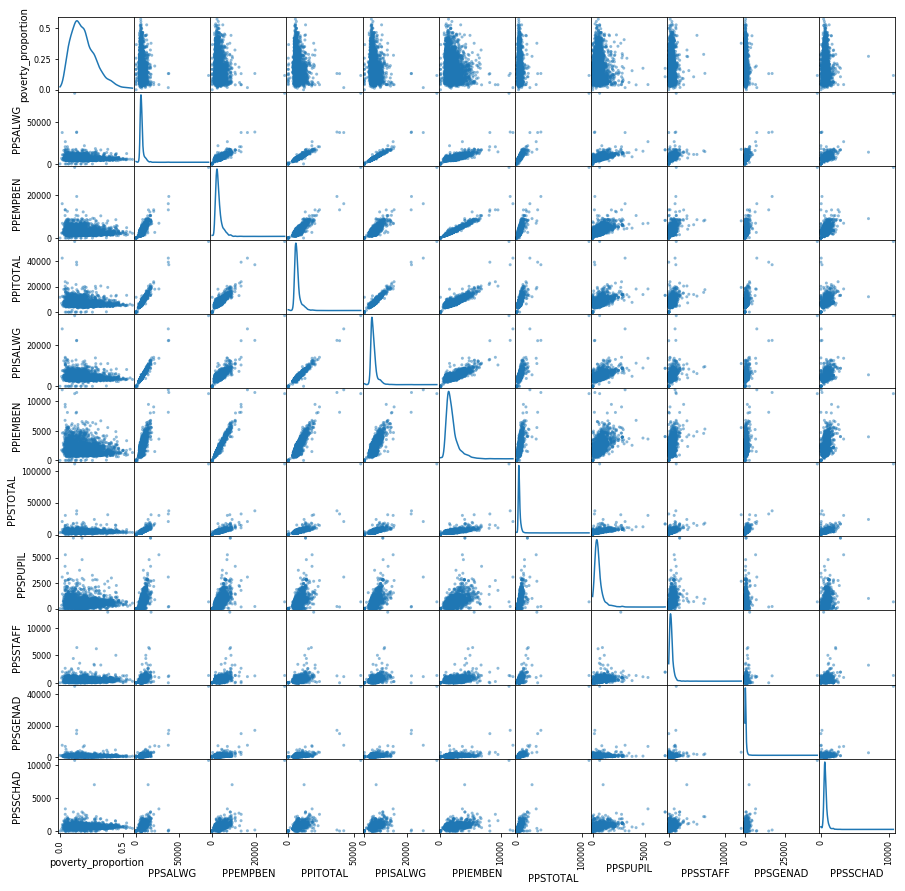

In [6]:
spend_data = an_pov[['Name', 'poverty_proportion'] + list(descriptions['Data Item '][56:].values)]
display(spend_data.head(5))

# save spend_data as an x and y matrix to help with plotting
X = spend_data.poverty_proportion
y = spend_data.loc[:, 'PPSALWG':]

# Create matrix scatter plot of our data
pd.plotting.scatter_matrix(spend_data.loc[:, 'poverty_proportion':], diagonal="kde", figsize=(15, 15))
plt.show()


## Sources

Data from the U.S. Census Bureau:

[Annual Survey of School System Finances](https://www.census.gov/programs-surveys/school-finances.html)

[SAIPE School District Estimates for 2016 ](https://www.census.gov/data/datasets/2016/demo/saipe/2016-school-districts.html)